# Creating and Tuning Models

This notebook will create, tune, and store a KNN and SVM model.<br>
For this, the data extracted utilising the feature extraction notebook will be used for training and testing.<br>
The testing split of this data will be stored to a CSV for later use with the webservice too.<br>

## Importing libraries

All utilised libraries are imported at the beginning of the notebook to avoid out of scope errors.<br>

In [1]:
import csv
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
import pandas as pd
from matplotlib import pyplot as plt

## Reading in CSV data

Reading the dataset from a CSV into a DataFrame for use with the model.<br>
Split into data and labels and carry out the train test split.<br>
The testing portion of the split will also be stored to CSV for later use with the webservice.<br>

In [2]:
music_df = pd.read_csv("extracted-features.csv")

# This will contain the data
data = music_df.iloc[:, 1:].values

# This will contain the labels corresponding to the data
labels = music_df.iloc[:, 0].values

# Split the data into training and testing sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.30)

# Combine testing labels and data and store as a CSV to be used later
testing_data = []
for i in range(0, len(labels_test), 1):
    testing_data.append([labels_test[i], data_test[i][0], data_test[i][1], data_test[i][2], data_test[i][3]])

with open("testing_data.csv", mode='w', newline='') as test_data_file:
    test_data_writer = csv.writer(test_data_file, delimiter=',')
    test_data_writer.writerow(["Genre", "MFCC", "ZCR", "Spectral Centroid", "Spectral Rolloff"])

    for i in range(0, len(testing_data), 1):
        test_data_writer.writerow(testing_data[i])

## Cross-validate KNN to find the best hyper-parameters

Use GridSearchCV to evaluate the optimal hyperparameters for the algorithm.<br>
Gridsearch utilises StratifiedKFold by default for cross validation.<br>
AUROC will be utilised as the metric for determining the best parameters for the model.<br>

{'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}
              precision    recall  f1-score   support

       Blues       0.24      0.31      0.27        32
   Classical       0.67      0.61      0.63        33
     Country       0.28      0.19      0.23        36
       Disco       0.12      0.13      0.12        31
      HipHop       0.17      0.19      0.18        31
        Jazz       0.28      0.21      0.24        34
       Metal       0.30      0.52      0.38        21
         Pop       0.41      0.60      0.49        20
      Reggae       0.23      0.26      0.24        27
        Rock       0.46      0.17      0.25        35

    accuracy                           0.30       300
   macro avg       0.32      0.32      0.30       300
weighted avg       0.32      0.30      0.29       300

ROC AUC: 0.7295784747150286


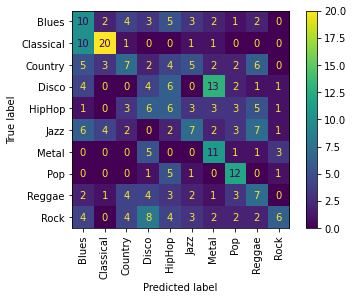

In [3]:
knn_model = KNeighborsClassifier()

param_grid = {"n_neighbors": range(1, 25),
              "weights": ["uniform", "distance"],
              "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]}

# roc_auc_ovr sets the score to use roc_auc in one vs rest mode
scoring_metrics = {"Accuracy": "accuracy",
                   "AUC": "roc_auc_ovr",
                   "F1": "f1_macro"}

knn_grid_search_cv = GridSearchCV(knn_model,
                                  param_grid,
                                  scoring=scoring_metrics,
                                  refit="AUC",
                                  cv=5)

knn_grid_search_cv.fit(data_train, labels_train)

print(knn_grid_search_cv.best_params_)

knn_grid_predict = knn_grid_search_cv.predict(data_test)

print(classification_report(labels_test, knn_grid_predict))

plot_confusion_matrix(estimator=knn_grid_search_cv,
                      X=data_test, y_true=labels_test,
                      xticks_rotation="vertical")

plt.show()

print("ROC AUC: " + str(knn_grid_search_cv.best_score_))

## Cross-validate SVM to find the best hyper-parameters

Use GridSearchCV to evaluate the optimal hyperparameters for the algorithm.<br>
Gridsearch utilises StratifiedKFold by default for cross validation.<br>
AUROC will be utilised as the metric for determining the best parameters for the model.<br>

{'C': 1000, 'gamma': 'scale'}
              precision    recall  f1-score   support

       Blues       0.46      0.19      0.27        32
   Classical       0.72      0.85      0.78        33
     Country       0.15      0.06      0.08        36
       Disco       0.20      0.29      0.23        31
      HipHop       0.38      0.26      0.31        31
        Jazz       0.21      0.21      0.21        34
       Metal       0.36      0.57      0.44        21
         Pop       0.41      0.60      0.49        20
      Reggae       0.27      0.52      0.35        27
        Rock       0.14      0.09      0.11        35

    accuracy                           0.34       300
   macro avg       0.33      0.36      0.33       300
weighted avg       0.32      0.34      0.31       300

ROC AUC: 0.7907554273926942


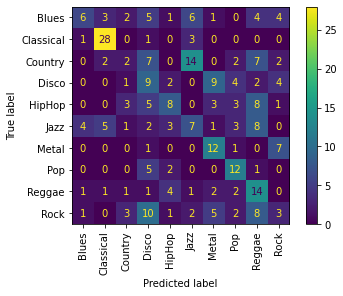

In [4]:
svm_model = SVC(probability=True, kernel="rbf")

param_grid = {"C": [0.1, 1, 10, 100, 1000],
              "gamma": ["scale", "auto"]}

# roc_auc_ovr sets the score to use roc_auc in one vs rest mode
scoring_metrics = {"Accuracy": "accuracy",
                   "AUC": "roc_auc_ovr",
                   "F1": "f1_macro"}

svm_grid_search_cv = GridSearchCV(svm_model,
                                  param_grid,
                                  scoring=scoring_metrics,
                                  refit="AUC",
                                  cv=5)

svm_grid_search_cv.fit(data_train, labels_train)

print(svm_grid_search_cv.best_params_)

svm_grid_predict = svm_grid_search_cv.predict(data_test)

print(classification_report(labels_test, svm_grid_predict))

plot_confusion_matrix(estimator=svm_grid_search_cv,
                      X=data_test, y_true=labels_test,
                      xticks_rotation="vertical")

plt.show()

print("ROC AUC: " + str(svm_grid_search_cv.best_score_))

## Save models

Save the tuned KNN and SVM models to a file.<br>
Each model will be serialized to a binary representation using the Pickle library.<br>
Each model is saved in a pre-trained, pre-tuned state.<br>

In [5]:
with open("models/knn.pkl", mode="wb") as model_file:
    pickle.dump(knn_grid_search_cv, model_file)

with open("models/svm.pkl", mode="wb") as model_file:
    pickle.dump(svm_grid_search_cv, model_file)